In [1]:

from __future__ import print_function, division
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import imageio
from torch.utils.data import Dataset
from PIL import Image


In [2]:
class ImageNet(Dataset):
    """Building an ImageNet Dataset object"""

    def __init__(self, root_dir,num_classes,num_samples,transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            num_classes (int): Number of classes
            num_samples (int): Number of samples for each classes   
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        datalist = []
        for i in range(num_classes):
            for j in range(num_samples): 
                datalist.append(glob.glob(root_dir+str(i)+'/*.JPEG')[j])
                
        self.datalist = datalist
        self.root_dir = root_dir
        self.transform = transform
        self.num_classes = num_classes
        self.num_samples = num_samples
        
        self.data_transforms = transforms.Compose([
        transforms.Resize((224,224)), #Resize
        transforms.ToTensor(), #Transform in pytorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Normalize with imagenet 
    ])
        
    def __len__(self):
        """Length of the dataset"""
        return len(self.datalist)

    def __getitem__(self, idx):
        """Return an item of the dataset as a tuple of"""
        img_name = self.datalist[idx]
        image = Image.open(img_name)
        if image.getbands()[0] == "L": # Check if the image is in RGB format if not converts it
            image = image.convert("RGB")
        label = img_name.split("/")[-2]
        sample = {'image': image, 'label': label}
        
        if self.transform: # Apply transformation
            image = self.data_transforms(image)
            
        return (image, label)
    


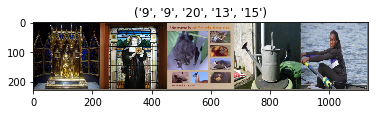

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Create an imagenet dataset with 25 classes and 250 samples per classes 
imagenet_dataset = ImageNet("/home/adrien/projet/data/images_classes/",25,250,transform=True)
plot_dataloader = torch.utils.data.DataLoader(imagenet_dataset, batch_size=5, num_workers=8,shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(plot_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot a few examples of the dataset
imshow(out, classes)



In [4]:
from torchsummary import summary

device = torch.device('cuda:0')

"""import and sum-up the resnet50 architecture"""

model_resnet50 = models.resnet50(pretrained=True)
model_resnet50 = model_resnet50.to(device)
model_resnet50.name = "resnet50"

model_inception3 = models.inception_v3(pretrained=True)
model_inception3 = model_inception3.to(device)
model_inception3.name = "inception3"

model_restnet152 = models.resnet152(pretrained=True)
model_restnet152 = model_restnet152.to(device)
model_restnet152.name = "resnet152"


model_vgg19 = models.vgg19(pretrained=True)
model_vgg19 = model_vgg19.to(device)
model_vgg19.name = "vgg19"


#summary(model_inception3,(3,224,224))

/home/brain/anaconda3/envs/env1/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU1 Quadro K420 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [15]:



class Identity(nn.Module):
    
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    

# Create a dataloader without shuffle to generate ordered feature vectors 
dataloader = torch.utils.data.DataLoader(imagenet_dataset, batch_size=32,num_workers=4)

#Freeze all the parameters

def infer_embeddings(model,dataloader):
    stacked_tensor = []
    label = []
    torch.cuda.empty_cache()
    model.fc = Identity()
    model.eval() 
    for i in tqdm(dataloader):
        [label.insert(len(label),x) for x in i[1]]
        stacked_tensor.append(model(i[0].to(device)).cpu().detach().numpy())
    
    return np.vstack(stacked_tensor),label

def generate_all_embeddings():
    descriptor ={}
    list_model = [model_vgg19,model_resnet50,model_restnet152]
    for element in list_model:
        vectors, labels = infer_embeddings(element,dataloader)
        descriptor[element.name] = vectors
    
    descriptor["label"] = labels
generate_all_embeddings()
#np.savez("pytorchresfv", nump)












  0%|          | 0/196 [00:00<?, ?it/s]








  1%|          | 1/196 [00:01<03:56,  1.21s/it]








  1%|          | 2/196 [00:01<03:17,  1.02s/it]








  2%|▏         | 3/196 [00:02<02:48,  1.15it/s]








  2%|▏         | 4/196 [00:02<02:28,  1.29it/s]








  3%|▎         | 5/196 [00:03<02:14,  1.42it/s]








  3%|▎         | 6/196 [00:03<02:04,  1.53it/s]








  4%|▎         | 7/196 [00:04<01:57,  1.61it/s]








  4%|▍         | 8/196 [00:05<01:52,  1.68it/s]








  5%|▍         | 9/196 [00:05<01:48,  1.73it/s]








  5%|▌         | 10/196 [00:06<01:45,  1.76it/s]








  6%|▌         | 11/196 [00:06<01:43,  1.79it/s]








  6%|▌         | 12/196 [00:07<01:41,  1.81it/s]








  7%|▋         | 13/196 [00:07<01:40,  1.82it/s]








  7%|▋         | 14/196 [00:08<01:39,  1.83it/s]








  8%|▊         | 15/196 [00:08<01:38,  1.84it/s]








  8%|▊         | 16/196 [00:09<01:37,  1.84it/s]








  9%|▊         | 17/196 [00:09<01:36,  1

 49%|████▉     | 97/196 [00:53<00:53,  1.85it/s]








 50%|█████     | 98/196 [00:53<00:53,  1.84it/s]








 51%|█████     | 99/196 [00:54<00:52,  1.85it/s]








 51%|█████     | 100/196 [00:54<00:51,  1.85it/s]








 52%|█████▏    | 101/196 [00:55<00:51,  1.85it/s]








 52%|█████▏    | 102/196 [00:55<00:50,  1.85it/s]








 53%|█████▎    | 103/196 [00:56<00:50,  1.85it/s]








 53%|█████▎    | 104/196 [00:56<00:49,  1.85it/s]








 54%|█████▎    | 105/196 [00:57<00:49,  1.85it/s]








 54%|█████▍    | 106/196 [00:57<00:48,  1.85it/s]








 55%|█████▍    | 107/196 [00:58<00:48,  1.85it/s]








 55%|█████▌    | 108/196 [00:59<00:47,  1.85it/s]








 56%|█████▌    | 109/196 [00:59<00:47,  1.85it/s]








 56%|█████▌    | 110/196 [01:00<00:46,  1.85it/s]








 57%|█████▋    | 111/196 [01:00<00:45,  1.85it/s]








 57%|█████▋    | 112/196 [01:01<00:45,  1.85it/s]








 58%|█████▊    | 113/196 [01:01<00:44,  1.85it/s]








 58%|█████▊    | 

 97%|█████████▋| 191/196 [01:43<00:02,  1.85it/s]








 98%|█████████▊| 192/196 [01:44<00:02,  1.85it/s]








 98%|█████████▊| 193/196 [01:45<00:01,  1.85it/s]








 99%|█████████▉| 194/196 [01:45<00:01,  1.85it/s]








 99%|█████████▉| 195/196 [01:46<00:00,  1.85it/s]








100%|██████████| 196/196 [01:46<00:00,  2.15it/s]

















  0%|          | 0/196 [00:00<?, ?it/s]








  1%|          | 1/196 [00:00<02:58,  1.09it/s]








  1%|          | 2/196 [00:01<02:17,  1.41it/s]








  2%|▏         | 3/196 [00:01<01:48,  1.78it/s]








  2%|▏         | 4/196 [00:01<01:28,  2.16it/s]








  3%|▎         | 5/196 [00:01<01:14,  2.55it/s]








  3%|▎         | 6/196 [00:02<01:04,  2.92it/s]








  4%|▎         | 7/196 [00:02<00:58,  3.25it/s]








  4%|▍         | 8/196 [00:02<00:53,  3.53it/s]








  5%|▍         | 9/196 [00:02<00:50,  3.73it/s]








  5%|▌         | 10/196 [00:02<00:47,  3.90it/s]








  6%|▌         | 11/196 [00:03<00:

 46%|████▋     | 91/196 [00:21<00:23,  4.39it/s]








 47%|████▋     | 92/196 [00:21<00:23,  4.39it/s]








 47%|████▋     | 93/196 [00:21<00:23,  4.34it/s]








 48%|████▊     | 94/196 [00:22<00:23,  4.36it/s]








 48%|████▊     | 95/196 [00:22<00:23,  4.38it/s]








 49%|████▉     | 96/196 [00:22<00:22,  4.38it/s]








 49%|████▉     | 97/196 [00:22<00:22,  4.39it/s]








 50%|█████     | 98/196 [00:23<00:22,  4.39it/s]








 51%|█████     | 99/196 [00:23<00:22,  4.39it/s]








 51%|█████     | 100/196 [00:23<00:21,  4.40it/s]








 52%|█████▏    | 101/196 [00:23<00:21,  4.41it/s]








 52%|█████▏    | 102/196 [00:23<00:21,  4.40it/s]








 53%|█████▎    | 103/196 [00:24<00:21,  4.40it/s]








 53%|█████▎    | 104/196 [00:24<00:20,  4.41it/s]








 54%|█████▎    | 105/196 [00:24<00:20,  4.41it/s]








 54%|█████▍    | 106/196 [00:24<00:20,  4.41it/s]








 55%|█████▍    | 107/196 [00:25<00:20,  4.41it/s]








 55%|█████▌    | 108/19

 94%|█████████▍| 185/196 [00:42<00:02,  4.40it/s]








 95%|█████████▍| 186/196 [00:43<00:02,  4.41it/s]








 95%|█████████▌| 187/196 [00:43<00:02,  4.34it/s]








 96%|█████████▌| 188/196 [00:43<00:01,  4.37it/s]








 96%|█████████▋| 189/196 [00:43<00:01,  4.39it/s]








 97%|█████████▋| 190/196 [00:44<00:01,  4.40it/s]








 97%|█████████▋| 191/196 [00:44<00:01,  4.39it/s]








 98%|█████████▊| 192/196 [00:44<00:00,  4.39it/s]








 98%|█████████▊| 193/196 [00:44<00:00,  4.35it/s]








 99%|█████████▉| 194/196 [00:44<00:00,  4.37it/s]








 99%|█████████▉| 195/196 [00:45<00:00,  4.38it/s]








100%|██████████| 196/196 [00:45<00:00,  4.33it/s]








  0%|          | 0/196 [00:00<?, ?it/s]








  1%|          | 1/196 [00:01<04:25,  1.36s/it]








  1%|          | 2/196 [00:01<03:36,  1.12s/it]








  2%|▏         | 3/196 [00:02<03:02,  1.06it/s]








  2%|▏         | 4/196 [00:03<02:39,  1.21it/s]








  3%|▎         | 5/196 [00:03<02

 43%|████▎     | 85/196 [00:47<01:02,  1.78it/s]








 44%|████▍     | 86/196 [00:48<01:01,  1.79it/s]








 44%|████▍     | 87/196 [00:48<01:00,  1.80it/s]








 45%|████▍     | 88/196 [00:49<00:59,  1.80it/s]








 45%|████▌     | 89/196 [00:49<00:59,  1.81it/s]








 46%|████▌     | 90/196 [00:50<00:58,  1.81it/s]








 46%|████▋     | 91/196 [00:51<00:57,  1.81it/s]








 47%|████▋     | 92/196 [00:51<00:57,  1.81it/s]








 47%|████▋     | 93/196 [00:52<00:56,  1.81it/s]








 48%|████▊     | 94/196 [00:52<00:56,  1.81it/s]








 48%|████▊     | 95/196 [00:53<00:55,  1.81it/s]








 49%|████▉     | 96/196 [00:53<00:55,  1.81it/s]








 49%|████▉     | 97/196 [00:54<00:54,  1.81it/s]








 50%|█████     | 98/196 [00:54<00:54,  1.80it/s]








 51%|█████     | 99/196 [00:55<00:53,  1.81it/s]








 51%|█████     | 100/196 [00:56<00:52,  1.81it/s]








 52%|█████▏    | 101/196 [00:56<00:52,  1.81it/s]








 52%|█████▏    | 102/196 [00:

 91%|█████████▏| 179/196 [01:39<00:09,  1.81it/s]








 92%|█████████▏| 180/196 [01:40<00:08,  1.81it/s]








 92%|█████████▏| 181/196 [01:40<00:08,  1.81it/s]








 93%|█████████▎| 182/196 [01:41<00:07,  1.81it/s]








 93%|█████████▎| 183/196 [01:41<00:07,  1.81it/s]








 94%|█████████▍| 184/196 [01:42<00:06,  1.81it/s]








 94%|█████████▍| 185/196 [01:42<00:06,  1.82it/s]








 95%|█████████▍| 186/196 [01:43<00:05,  1.81it/s]








 95%|█████████▌| 187/196 [01:44<00:04,  1.81it/s]








 96%|█████████▌| 188/196 [01:44<00:04,  1.81it/s]








 96%|█████████▋| 189/196 [01:45<00:03,  1.81it/s]








 97%|█████████▋| 190/196 [01:45<00:03,  1.81it/s]








 97%|█████████▋| 191/196 [01:46<00:02,  1.81it/s]








 98%|█████████▊| 192/196 [01:46<00:02,  1.80it/s]








 98%|█████████▊| 193/196 [01:47<00:01,  1.81it/s]








 99%|█████████▉| 194/196 [01:47<00:01,  1.81it/s]








 99%|█████████▉| 195/196 [01:48<00:00,  1.81it/s]








100%|█████████

# Compute the distance matrix for each descriptors 

In [ ]:
def computeinterscore(A,B):
    score = sp.spatial.distance.cdist(A,B,metric='cosine').sum()/sp.spatial.distance.cdist(A,B).size
    return score


def distancematrix(vec):
    i_index=0
    j_index=0
    result = []
    for i in categories:
        i_index = categories.index(i)*num_samples
        intra = computeinterscore(vec[i_index:(i_index+num_samples)],vec[i_index:(i_index+num_samples)])
        for j in categories:
            j_index = categories.index(j)*num_samples
            inter = computeinterscore(vec[i_index:(i_index+num_samples)],vec[j_index:(j_index+num_samples)])
            result.append(intra/inter)
    result = np.matrix(result).reshape((num_classes,num_classes)) #reshape as matrix
    return result
    
    
def plotdistancematrix(descriptors):
    j = 0
    w=0
    fig1 = plt.figure()
    fig1.suptitle('Distance Matrix with cosine distance', fontsize=20)
    fig1.set_size_inches(15,10)
    for elements,name in zip([iv3vec,nasvec,resnetvec],["Inception_V3","Nasnet","ResNet"]):
        axe = fig1.add_subplot(2,2,j+1)
        axe.set_xlabel('Number of samples')
        axe.set_ylabel('Accuracy %')
        print(elements.shape)
        value = distancematrix(elements)
        print(name)
        ax = sns.heatmap(value,label="HELLO")
        ax.xaxis.set_ticks_position('top')
        plt.title(name,size='13',pad=30)
        j += 1 

plotdistancematrix(featuresveciv3,featuresvecnas,featuresvecresnet)

In [ ]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

x_train, x_test, y_train, y_test = model_selection.train_test_split(nump, label, test_size=.25,random_state=42,stratify=label)
knn = KNeighborsClassifier(10, metric='cosine')
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

In [ ]:

def stress(features, L,  n_tests):
    scores = np.zeros((4))
    for i in range(n_tests):
        classifiers = [KNeighborsClassifier(metric='cosine'), SVC(), RandomForestClassifier(), MLPClassifier(hidden_layer_sizes=(500,500,))]
        X_train, X_test, y_train, y_test = model_selection.train_test_split(features, L, test_size=.25)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        for i in range(len(classifiers)):
            clf = classifiers[i]
            clf.fit(X_train,y_train)
            scores[i] += clf.score(X_test,y_test)
    return scores/n_tests


def selectsubset(featuresvec, size, L):
    i=0
    index= np.zeros((1,size))
    for values in range(num_classes):
        i += num_samples 
        a = np.random.randint(i-num_samples,i ,size=size)
        index = np.append(index,a)
    sampeled = featuresvec[index[size:].astype(int)]
    Lab = L[index[size:].astype(int)]
    return sampeled, Lab

def estimatefvquality(descriptors, L, numsubtest):
    sns.set_palette(sns.color_palette("hls", 4))
    paper_rc = {'lines.linewidth': 3}                  
    sns.set_context("paper", rc = paper_rc) 
    i=0
    result ={
    "inceptionv3" :np.zeros((0,4)), 
    "resnet50":np.zeros((0,4)), 
    "nasnet":np.zeros((0,4)),
    "resnet152":np.zeros((0,4))
    }
    
   
    xticks = [i for i in range(2,num_samples,5)]
    for xtick in tqdm(xticks):
        for j,key in enumerate(descriptors):
            subvec, sublabel = selectsubset(descriptors[key],xtick,L)
            result[key] = np.concatenate((np.expand_dims(stress(subvec, sublabel,numsubtest),axis=0),result[key]),axis=0)

            
            
    fig1 = plt.figure()
    fig1.suptitle('Transfer performance using resnet50 nasnet and iv3 as descriptors', fontsize=16)
    fig1.set_size_inches(15,10)        
    
    for i,algo in enumerate(["KNN","SVM","RF","MLP"]):
        df = pd.DataFrame({'accuracy':[], 'network':[]})
        axe = fig1.add_subplot(2,2,i+1)
        axe.set_title(algo)
        axe.set_xlabel('Number of samples')
        axe.set_ylabel('Accuracy %')
        for key in result:
            df["accuracy"] = pd.Series(result[key][:,i][::-1],index=xticks)
            sns.lineplot(y=df["accuracy"].values,x=df.index.values,label=key)


In [ ]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

def stress(features, L,  n_tests):
    scores = np.zeros((4))
    for i in range(n_tests):
        classifiers = [KNeighborsClassifier(metric='cosine'), SVC(), RandomForestClassifier(), MLPClassifier(hidden_layer_sizes=(500,500,))]
        X_train, X_test, y_train, y_test = model_selection.train_test_split(features, L, test_size=.25)

        for i in range(len(classifiers)):
            clf = classifiers[i]
            clf.fit(X_train,y_train)
            scores[i] += clf.score(X_test,y_test)
    return scores/n_tests

stress(nump,label,4)